# Project 3: Collaboration and Competition

This notebook provides the main part of code for training the agents. Beyond this notebook, the Python files 'actor_critic_networks.py', 'deep_det_policy_grad_agent.py' and 'deep_det_policy_grad_multi_agents.py' are necessary for successfully solving this collaboration and competition project.

### 1. Set the framework

First, load necessary packages.

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from unityagents import UnityEnvironment
from collections import deque
from deep_det_policy_grad_multi_agents import MADDPG

Now, start the environment.

In [2]:
env = UnityEnvironment(file_name="C:/Users/DNEUHAE/Desktop/DRL/p3_collab-compet/Tennis_Windows_x86_64/Tennis.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Initialize the agents

In [3]:
from actor_critic_networks import Actor_2HL_BN, Critic_2HL_BN, Actor_1HL, Critic_3HL_leaky

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

# extract size information for action space and state space  
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

Now, we initialize two types of actor-critic-agents. The first architecture type ('MA_actor_critic_2x2_BN') has an actor network with 2 hidden layers and a critic network with 2 hidden layers, each equipped with batch normalization. The second architecture ('MA_actor_critic_1x3_leaky') has an actor network with 1 hidden layer and a critic network with 3 hidden layers, each equipped with leaky relus. Thus, the difference between the actor-critic-agents is the architecture of the neural nets. Note that the individual architecture for each of the two agents is within one architecture type always the same, i.e. both agents are of type 'actor_critic_2x2_BN' or both agents are of type 'actor_critic_1x3_leaky'.  

In [4]:
MA_actor_critic_2x2_BN = MADDPG(action_size=action_size, state_size=state_size, random_seed=0, actor_net=Actor_2HL_BN, critic_net=Critic_2HL_BN)
MA_actor_critic_1x3_leaky = MADDPG(action_size=action_size, state_size=state_size, random_seed=0, actor_net=Actor_1HL, critic_net=Critic_3HL_leaky)

### 3. Train the agents via Multi-Agent Deep Deterministic Policy Gradient

In [5]:
def maddpg(n_episodes, max_t, agents, pth_filename_act, pth_filename_cri):
    """
    Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int): number of training episodes
        max_t (int): maximum number of timesteps per episode
        agent (Agent object): Actor-Critic-Agent with specified network architecture 
        pth_filename_act (str): name for the '*.pth'-file for actors
        pth_filename_cri (str): name for the '*.pth'-file for critics
    """
    
    scores = []                                                # list containing scores from each episode   
    scores_window = deque(maxlen=100)                          # store only the last 100 scores
    
    for n_episode in range(1, n_episodes+1):                   # run n_episodes
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)                           # initialize the score (for each agent)
        
        for t in range(max_t):                                 # run for maximum of max_t timesteps 
            actions = agents.act(states, noise=True)           # get the actions
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations         # get the states
            rewards = env_info.rewards                         # get the rewards
            dones = env_info.local_done                        # is the episode complete or not
            agents.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            score += rewards
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        scores_window.append(np.max(score))
        scores.append(np.max(score))
        
        if n_episode % 100 == 0:
            print('\rEpisode {}... Average Score: {:.2f}'.format(n_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes... Average Score: {:.2f}'.format(n_episode, np.mean(scores_window)))
            agents.save_trained_agents(pth_filename_act=pth_filename_act,pth_filename_cri=pth_filename_cri)
            break
            
    return scores

#### 3.1 Actor-Critic-Agents via 'MA_actor_critic_2x2_BN'

In [6]:
scores = maddpg(n_episodes=10000, 
                max_t=1000, 
                agents=MA_actor_critic_2x2_BN,
                pth_filename_act='actor_2x2_BN',
                pth_filename_cri='critic_2x2_BN'
                )

Episode 100... Average Score: 0.00
Episode 200... Average Score: 0.00
Episode 300... Average Score: 0.03
Episode 400... Average Score: 0.00
Episode 500... Average Score: 0.00
Episode 600... Average Score: 0.00
Episode 700... Average Score: 0.02
Episode 800... Average Score: 0.02
Episode 900... Average Score: 0.05
Episode 1000... Average Score: 0.06
Episode 1100... Average Score: 0.07
Episode 1200... Average Score: 0.07
Episode 1300... Average Score: 0.05
Episode 1400... Average Score: 0.05
Episode 1500... Average Score: 0.06
Episode 1600... Average Score: 0.07
Episode 1700... Average Score: 0.07
Episode 1800... Average Score: 0.08
Episode 1900... Average Score: 0.09
Episode 2000... Average Score: 0.11
Episode 2100... Average Score: 0.14
Episode 2200... Average Score: 0.19
Episode 2300... Average Score: 0.12

Environment solved in 2388 episodes... Average Score: 0.51


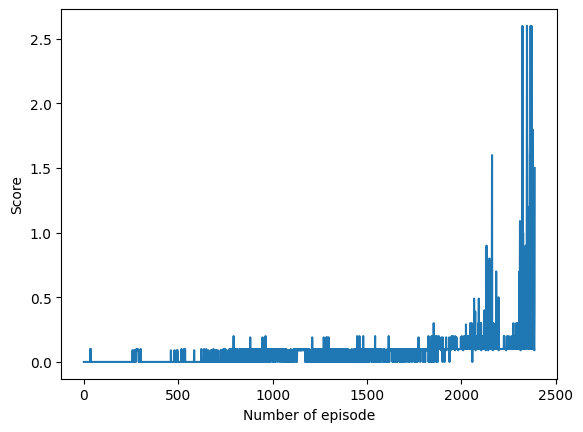

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Number of episode')
plt.savefig('C:/Users/DNEUHAE/Desktop/DRL/p3_collab-compet/actor_critic_2x2_BN.png', bbox_inches='tight')
plt.show()

#### 3.2 Actor-Critic-Agents via 'MA_actor_critic_1x3_leaky'

In [6]:
scores = maddpg(n_episodes=10000, 
                max_t=1000, 
                agents=MA_actor_critic_1x3_leaky,
                pth_filename_act='actor_1x3_leaky',
                pth_filename_cri='critic_1x3_leaky'
               )

Episode 100... Average Score: 0.00
Episode 200... Average Score: 0.00
Episode 300... Average Score: 0.00
Episode 400... Average Score: 0.00
Episode 500... Average Score: 0.00
Episode 600... Average Score: 0.00
Episode 700... Average Score: 0.01
Episode 800... Average Score: 0.01
Episode 900... Average Score: 0.00
Episode 1000... Average Score: 0.02
Episode 1100... Average Score: 0.02
Episode 1200... Average Score: 0.01
Episode 1300... Average Score: 0.00
Episode 1400... Average Score: 0.02
Episode 1500... Average Score: 0.06
Episode 1600... Average Score: 0.05
Episode 1700... Average Score: 0.01
Episode 1800... Average Score: 0.00
Episode 1900... Average Score: 0.00
Episode 2000... Average Score: 0.03
Episode 2100... Average Score: 0.07
Episode 2200... Average Score: 0.10
Episode 2300... Average Score: 0.10
Episode 2400... Average Score: 0.14
Episode 2500... Average Score: 0.11
Episode 2600... Average Score: 0.12
Episode 2700... Average Score: 0.14
Episode 2800... Average Score: 0.20
E

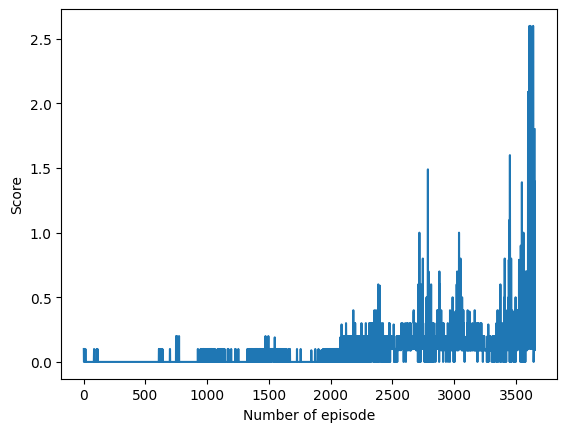

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Number of episode')
plt.savefig('C:/Users/DNEUHAE/Desktop/DRL/p3_collab-compet/actor_critic_1x3_leaky.png', bbox_inches='tight')
plt.show()

In [ ]:
env.close()